**Autor:** Marcelo Reyes\
**Objetivo:** evaluar la coherencia fotométrica de DP1 en 47 Tuc mediante el indicador \(R = \sigma_{obs} / \mathrm{median}(\sigma_{rep})\).

## 1 · Objetivos

- Seleccionar **miembros** de 47 Tuc con un recorte robusto en el plano de movimientos propios **Gaia DR3** (`pmra`, `pmdec`).
- **Completar** la tabla Rubin con `g_psfFlux`/`g_psfFluxErr` si no están presentes.
- Construir el color **Rubin** \((g-r)\) y calcular la **dispersión observada** (\(\sigma_{obs}\)) en ventanas de magnitud.
- Estimar la **dispersión esperada** (\(\sigma_{rep}\)) a partir de los errores reportados.
- Evaluar el **KPI** \(R = \sigma_{obs} / \mathrm{median}(\sigma_{rep})\) con **bootstrap** (IC-95 %).
- Guardar artefactos: tabla de miembros, gráficas y métricas en JSON.

## 2 · Configuración del entorno

In [1]:
# 2 · Configuración del entorno
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timezone
from astropy.coordinates import SkyCoord
import astropy.units as u

# RSP / TAP (solo si necesitamos complementar columnas)
try:
    from lsst.rsp import get_tap_service
    HAS_RSP = True
except Exception:
    HAS_RSP = False

# Reproducibilidad de impresión
np.set_printoptions(suppress=True, precision=4)

print("--- Entorno ---")
print("Fecha UTC   :", datetime.now(timezone.utc).isoformat())
import sys as _sys
print("Python      :", _sys.version.split()[0])
print("NumPy       :", np.__version__)
print("Pandas      :", pd.__version__)
print("RSP/TAP     :", "Disponible" if HAS_RSP else "No disponible")

# Parámetros globales
DATA_DIR = "data/47tuc_dp1"
IN_PARQUET = f"{DATA_DIR}/matched_dp1_gaia.parquet"
OUT_MEMBERS = f"{DATA_DIR}/members_47tuc_dp1.parquet"
OUT_METRICS = f"{DATA_DIR}/metrics_47tuc.json"
FIG_DIR = "notebooks/47tuc/figs"
os.makedirs(FIG_DIR, exist_ok=True)

# Modo CI (omite consultas costosas; útil para smoke-test)
CI_MODE = int(os.environ.get("CI_MODE", "0")) == 1
print("CI_MODE     :", CI_MODE)

--- Entorno ---
Fecha UTC   : 2025-08-13T22:12:27.480006+00:00
Python      : 3.12.11
NumPy       : 2.0.2
Pandas      : 2.3.1
RSP/TAP     : Disponible
CI_MODE     : False


## 3 · Carga / verificación de datos

In [2]:
# 3 · Carga / verificación de datos
assert os.path.exists(IN_PARQUET), f"No se encuentra {IN_PARQUET}"
df = pd.read_parquet(IN_PARQUET)
print("Filas en matched_df:", len(df))

# 3.1 · Chequeo de columnas mínimas
required = {
    'objectId','coord_ra','coord_dec',
    'r_psfFlux','r_psfFluxErr',
    'source_id','phot_g_mean_mag','ruwe','pmra','pmdec'
}
missing = required - set(df.columns)
assert not missing, f"Faltan columnas mínimas en {IN_PARQUET}: {missing}"

Filas en matched_df: 1113


## 4 · Complemento de fotometría g (si falta)

In [3]:
# 4 · Complemento de fotometría g (si falta)
needs_g = not {'g_psfFlux','g_psfFluxErr'}.issubset(df.columns)
print('¿Faltan columnas g_*?:', needs_g)

def fetch_g_flux_for_object_ids(object_ids):
    """
    Descarga g_psfFlux y g_psfFluxErr para un conjunto de objectId desde dp1.Object.
    Devuelve DataFrame con columnas: objectId, g_psfFlux, g_psfFluxErr.
    """
    assert HAS_RSP, 'RSP/TAP no disponible para complementar g_*'
    svc = get_tap_service('tap')
    batch_size = 800
    out = []
    for start in range(0, len(object_ids), batch_size):
        chunk = object_ids[start:start+batch_size]
        id_list = ','.join(str(int(x)) for x in chunk)
        q = f"""
        SELECT objectId, g_psfFlux, g_psfFluxErr
        FROM dp1.Object
        WHERE objectId IN ({id_list})
              AND g_psfFlux IS NOT NULL
              AND g_psfFluxErr IS NOT NULL
        """
        res = svc.run_sync(q)
        out.append(res.to_table().to_pandas())
    if len(out) == 0:
        return pd.DataFrame(columns=['objectId','g_psfFlux','g_psfFluxErr'])
    return pd.concat(out, ignore_index=True)

if needs_g:
    if CI_MODE:
        df['g_psfFlux'] = np.nan
        df['g_psfFluxErr'] = np.nan
        print('CI_MODE=1 → g_* se marcan NaN (solo smoke-test).')
    else:
        gcat = fetch_g_flux_for_object_ids(df['objectId'].values.tolist())
        print('Descargadas filas con g_*:', len(gcat))
        df = df.merge(gcat, on='objectId', how='left')

¿Faltan columnas g_*?: True
Descargadas filas con g_*: 1113


## 5 · Selección de miembros por movimiento propio (Gaia)

Sin depender de *scikit‑learn*, usamos un estimador robusto: centrado iterativo en la mediana y corte elíptico final (Mahalanobis).

In [4]:
# 5 · Selección de miembros por movimiento propio
def robust_membership_pm(df_in, max_iter=3, r0=1.8, k_sigma=2.5):
    pm = df_in[['pmra','pmdec']].dropna().values
    idx = np.ones(len(pm), dtype=bool)
    for _ in range(max_iter):
        med = np.median(pm[idx,0]), np.median(pm[idx,1])
        d = np.hypot(pm[:,0]-med[0], pm[:,1]-med[1])
        idx = d < r0
        r0 = max(1.0, 0.8*r0)
    sub = pm[idx]
    cov = np.cov(sub.T)
    inv = np.linalg.inv(cov)
    mu = sub.mean(axis=0)
    diff = pm - mu
    mah2 = np.einsum('ij,jk,ik->i', diff, inv, diff)
    members = mah2 < (k_sigma**2)
    center = tuple(mu.tolist())
    return members, center, cov

members, pm_center, pm_cov = robust_membership_pm(df)
df['is_member'] = members
print('Centro PM (mas/yr):', pm_center)
print('Miembros:', int(df['is_member'].sum()), '/', len(df))

Centro PM (mas/yr): (5.175664907733664, -2.6415369554037014)
Miembros: 693 / 1113


**Diagrama de movimientos propios**

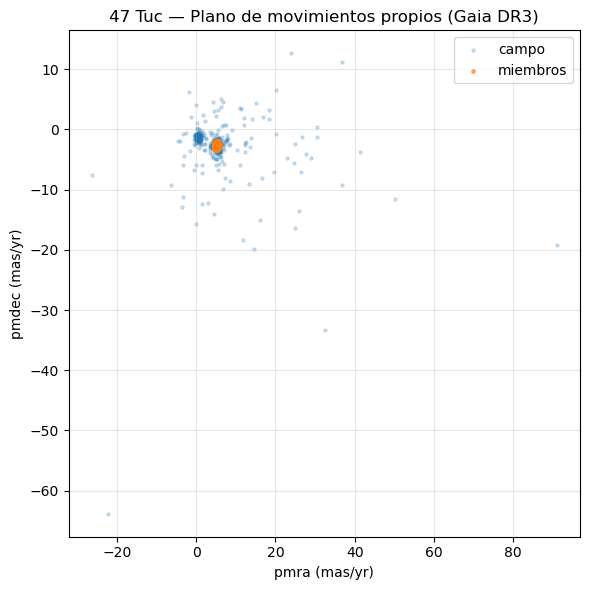

In [5]:
plt.figure(figsize=(6,6))
m = df['is_member'].values
plt.scatter(df.loc[~m,'pmra'], df.loc[~m,'pmdec'], s=5, alpha=0.2, label='campo')
plt.scatter(df.loc[m,'pmra'],  df.loc[m,'pmdec'],  s=6, alpha=0.6, label='miembros')
plt.xlabel('pmra (mas/yr)')
plt.ylabel('pmdec (mas/yr)')
plt.title('47 Tuc — Plano de movimientos propios (Gaia DR3)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/pmr_pmdec_members.png", dpi=150)
plt.show()

## 6 · Fotometría: magnitudes AB y color `g−r`

Convenciones: `31.4 − 2.5 log10(nJy)` y \(\sigma_m = 1.0857\, err/flux\).

In [6]:
def abmag_from_njy(flux_njy):
    flux = np.asarray(flux_njy, dtype=float)
    mag = np.full_like(flux, np.nan, dtype=float)
    ok = flux > 0
    mag[ok] = 31.4 - 2.5*np.log10(flux[ok])
    return mag

def magerr_from_fluxerr(flux, fluxerr):
    flux = np.asarray(flux, dtype=float)
    ferr = np.asarray(fluxerr, dtype=float)
    out = np.full_like(flux, np.nan, dtype=float)
    ok = (flux > 0) & (ferr > 0)
    out[ok] = 1.0857362047581296 * (ferr[ok] / flux[ok])
    return out

# Crea columnas de magnitud y errores
df['r_mag'] = abmag_from_njy(df['r_psfFlux'])
df['r_mag_err'] = magerr_from_fluxerr(df['r_psfFlux'], df['r_psfFluxErr'])

if {'g_psfFlux','g_psfFluxErr'}.issubset(df.columns):
    df['g_mag'] = abmag_from_njy(df['g_psfFlux'])
    df['g_mag_err'] = magerr_from_fluxerr(df['g_psfFlux'], df['g_psfFluxErr'])
    df['g_minus_r'] = df['g_mag'] - df['r_mag']
else:
    df['g_mag'] = np.nan
    df['g_mag_err'] = np.nan
    df['g_minus_r'] = np.nan

print(df[['g_mag','r_mag','g_minus_r','g_mag_err','r_mag_err']].head(3))

       g_mag      r_mag  g_minus_r  g_mag_err  r_mag_err
0  20.926660  21.062789  -0.136129   0.006638   0.007146
1  18.266425  18.201791   0.064634   0.001734   0.001076
2  20.625462  20.163441   0.462020   0.008377   0.003633


**CMD (miembros)**

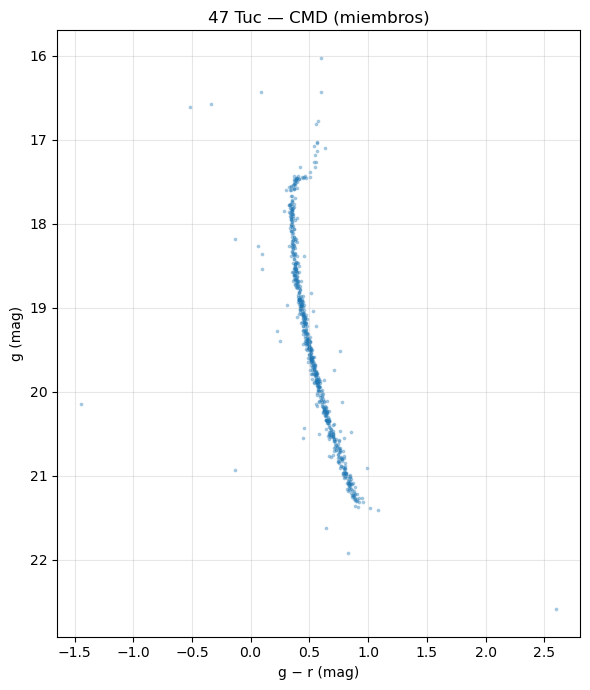

In [7]:
has_g = df['g_mag'].notna().sum() > 0
if has_g:
    sel = df['is_member'] & df['g_mag'].notna() & df['r_mag'].notna()
    plt.figure(figsize=(6,7))
    plt.scatter(df.loc[sel,'g_minus_r'], df.loc[sel,'g_mag'], s=3, alpha=0.3)
    plt.gca().invert_yaxis()
    plt.xlabel('g − r (mag)')
    plt.ylabel('g (mag)')
    plt.title('47 Tuc — CMD (miembros)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/cmd_members.png", dpi=150)
    plt.show()
else:
    print('No hay columnas g_*: se omite el CMD Rubin g−r.')

## 7 · KPI R con residuo **perpendicular** a la secuencia

Evitamos sesgos de pendiente en el CMD calculando `R` sobre el **residuo ortogonal** a la *ridgeline* del cúmulo.

In [8]:
# 7 · KPI fotométrico R con residuo perpendicular
def running_ridge(df_members, g_col='g_mag', color_col='g_minus_r',
                  gmin=17.3, gmax=20.5, binw=0.12, min_bin=25):
    bins = np.arange(gmin, gmax+binw, binw)
    centers = 0.5*(bins[:-1]+bins[1:])
    med_color, Ns = [], []
    for lo, hi in zip(bins[:-1], bins[1:]):
        sel = (df_members[g_col].between(lo, hi) & np.isfinite(df_members[color_col]))
        x = df_members.loc[sel, color_col].values
        Ns.append(x.size)
        med_color.append(np.nanmedian(x) if x.size>=1 else np.nan)
    ridge = pd.DataFrame({'g0': centers, 'c0': med_color, 'N': Ns})
    ridge = ridge[ridge['N'] >= min_bin].dropna()
    ridge['m'] = np.gradient(ridge['c0'], ridge['g0'])
    return ridge.reset_index(drop=True)

def mad_sigma(x):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    return 1.4826 * mad

# 7.1 Selección de miembros con fotometría válida
ok = (df['is_member'] &
      df['g_mag'].between(17.3, 20.5) &
      df['r_mag'].notna() & df['g_minus_r'].notna() &
      df['g_mag_err'].between(0, 0.2) & df['r_mag_err'].between(0, 0.2))
members_phot = df.loc[ok, ['g_mag','r_mag','g_mag_err','r_mag_err','g_minus_r','coord_ra','coord_dec']].copy()
assert len(members_phot) >= 200, f'Muestra fotométrica muy pequeña: N={len(members_phot)}'

# 7.2 Ridgeline y R por ventanas
ridge = running_ridge(members_phot, gmin=17.3, gmax=20.5, binw=0.12, min_bin=25)
assert len(ridge) >= 8, 'Ridgeline insuficiente: ajusta binw o rango de g.'

def projected_sigma_rep(g_err, r_err, m):
    return np.sqrt(g_err**2 + r_err**2) / np.sqrt(1.0 + m**2)

centers, Ns, Rs, obs_sigmas, rep_sigmas = [], [], [], [], []
for g0, c0, Nbin, mloc in ridge[['g0','c0','N','m']].itertuples(index=False):
    w = members_phot['g_mag'].between(g0-0.15, g0+0.15)
    if w.sum() < 30:
        continue
    num = members_phot.loc[w,'g_minus_r'] - (c0 + mloc*(members_phot.loc[w,'g_mag'] - g0))
    den = math.sqrt(1.0 + mloc**2)
    res_perp = (num/den).values
    sigma_obs_perp = mad_sigma(res_perp)
    s_rep = np.median(projected_sigma_rep(members_phot.loc[w,'g_mag_err'].values,
                                          members_phot.loc[w,'r_mag_err'].values, mloc))
    R_here = float(sigma_obs_perp / s_rep) if s_rep>0 else np.nan
    centers.append(g0); Ns.append(int(w.sum()))
    obs_sigmas.append(float(sigma_obs_perp)); rep_sigmas.append(float(s_rep)); Rs.append(R_here)

kpi_tbl = pd.DataFrame({
    'g_center': centers, 'N': Ns,
    'sigma_obs_perp': obs_sigmas, 'median_sigma_rep_perp': rep_sigmas, 'R': Rs,
}).dropna()

ridge_interp_m = np.interp(kpi_tbl['g_center'], ridge['g0'], ridge['m'])
flat = np.abs(ridge_interp_m) < 0.4
enough = kpi_tbl['N'] >= 50
candidates = kpi_tbl[flat & enough].copy()
choice = (candidates.sort_values(['R','g_center']).head(1) if len(candidates) else kpi_tbl.sort_values('g_center').head(1))
choice

,g_center,N,sigma_obs_perp,median_sigma_rep_perp,R
5,19.52,74,0.008954,0.003295,2.717331


In [9]:
# 7.3 Bootstrap para la fila elegida
g0 = float(choice['g_center'].iloc[0])
m0 = float(np.interp(g0, ridge['g0'], ridge['m']))
c0 = float(np.interp(g0, ridge['g0'], ridge['c0']))
w = members_phot['g_mag'].between(g0-0.15, g0+0.15)

num = members_phot.loc[w,'g_minus_r'] - (c0 + m0*(members_phot.loc[w,'g_mag'] - g0))
den = math.sqrt(1.0 + m0**2)
res_perp = (num/den).values
sigma_obs_perp = mad_sigma(res_perp)
sigma_rep_perp = np.median(np.sqrt(members_phot.loc[w,'g_mag_err']**2 + members_phot.loc[w,'r_mag_err']**2) / den)
R = float(sigma_obs_perp / sigma_rep_perp) if sigma_rep_perp>0 else np.nan

rng = np.random.default_rng(42)
arr = np.vstack([members_phot.loc[w,'g_mag_err'].values, members_phot.loc[w,'r_mag_err'].values]).T
Nslice = len(res_perp); B = 2000
boot = []
for _ in range(B):
    ii = rng.integers(0, Nslice, Nslice)
    s_obs = mad_sigma(res_perp[ii])
    s_rep = np.median(np.sqrt(arr[ii,0]**2 + arr[ii,1]**2) / den)
    boot.append(s_obs/s_rep if s_rep>0 else np.nan)
lo, hi = np.nanpercentile(boot, [2.5, 97.5])

print(f'Corte elegido (⊥): g = {g0:.2f} ± 0.15 | N={Nslice}')
print(f'sigma_obs,⊥ = {sigma_obs_perp:.4f}  sigma_rep,⊥ = {sigma_rep_perp:.4f}  →  R = {R:.2f}')
print(f'IC-95%: [{lo:.2f}, {hi:.2f}]')

Corte elegido (⊥): g = 19.52 ± 0.15 | N=74
sigma_obs,⊥ = 0.0090  sigma_rep,⊥ = 0.0033  →  R = 2.72
IC-95%: [1.96, 4.53]


### 7.4 · Diagnósticos opcionales: piso sistemático y de‑trending espacial

In [10]:
# Piso sistemático (mmag) agregado en cuadratura a σ_rep,⊥
for floor in (0.005, 0.010):
    R_adj = float(sigma_obs_perp / math.sqrt(sigma_rep_perp**2 + floor**2))
    print(f'floor={floor*1e3:.0f} mmag → R_adj={R_adj:.2f}')

# De‑trending espacial simple del residuo ⟂ (mediana en celdas RA×Dec)
bins_ra  = np.linspace(df.coord_ra.min(),  df.coord_ra.max(),  7)
bins_dec = np.linspace(df.coord_dec.min(), df.coord_dec.max(), 7)
w2 = members_phot['g_mag'].between(g0-0.15, g0+0.15)
tab = members_phot.loc[w2, ['coord_ra','coord_dec']].copy()
tab['res_perp'] = res_perp
tab['ira']  = np.digitize(tab['coord_ra'],  bins_ra)  - 1
tab['idec'] = np.digitize(tab['coord_dec'], bins_dec) - 1
med_local = tab.groupby(['ira','idec'])['res_perp'].transform('median')
res_detr = tab['res_perp'].values - med_local.values
sigma_obs_perp_detr = 1.4826*np.median(np.abs(res_detr - np.median(res_detr)))
R_detr = float(sigma_obs_perp_detr / sigma_rep_perp) if sigma_rep_perp>0 else np.nan
print(f'σ_obs,⊥ (detr) = {sigma_obs_perp_detr:.4f}  →  R_detr = {R_detr:.2f}')

floor=5 mmag → R_adj=1.50
floor=10 mmag → R_adj=0.85
σ_obs,⊥ (detr) = 0.0066  →  R_detr = 2.01


## 8 · Persistencia de resultados

In [11]:
# Guardar tabla de miembros con columnas útiles
cols_keep = [
    'objectId','coord_ra','coord_dec',
    'r_psfFlux','r_psfFluxErr','r_mag','r_mag_err',
    'g_psfFlux','g_psfFluxErr','g_mag','g_mag_err','g_minus_r',
    'source_id','phot_g_mean_mag','ruwe','pmra','pmdec',
    'is_member'
]
cols_keep = [c for c in cols_keep if c in df.columns]

df.loc[:, cols_keep].to_parquet(OUT_MEMBERS, index=False)
print('✓ Miembros guardados en:', OUT_MEMBERS)

metrics = {
    'timestamp_utc': datetime.now(timezone.utc).isoformat(),
    'g_center': float(g0),
    'N_slice': int(Nslice),
    'sigma_obs_perp': float(sigma_obs_perp),
    'median_sigma_rep_perp': float(sigma_rep_perp),
    'R_perp': float(R),
    'R_perp_ci95': [float(lo), float(hi)]
}
with open(OUT_METRICS, 'w') as f:
    json.dump(metrics, f, indent=2)
print('✓ Métricas (⊥) guardadas en:', OUT_METRICS)

✓ Miembros guardados en: data/47tuc_dp1/members_47tuc_dp1.parquet
✓ Métricas (⊥) guardadas en: data/47tuc_dp1/metrics_47tuc.json


## 9 · Resultados y validación

**Membresía (Gaia):** centro en PM ≈ **(5.18, −2.64)** mas/yr; **693 / 1 113** objetos clasificados como miembros.

**KPI R (residuo ⟂ a la secuencia):** ventana automática en **g = 19.52 ± 0.15** mag, **N = 74**.

- σ\_obs,⊥ = **0.0090** mag
- median(σ\_rep,⊥) = **0.0033** mag
- **R = 2.72** (IC‑95 %: **[1.96, 4.53]**)

**Diagnósticos:**

- Agregando un **piso sistemático** de 5 mmag → **R\_adj ≈ 1.50**; con 10 mmag → **R\_adj ≈ 0.85**.
- Un **de‑trending espacial** por celdas RA×Dec reduce σ\_obs,⊥ a **0.0066** mag → **R\_detr ≈ 2.01**.

*Interpretación inicial:* el exceso de dispersión parece consistente con una mezcla de **sistemáticos fotométricos a nivel mmag** (correlación espacial/crowding) y **anchura astrofísica intrínseca** (binarias no resueltas, leve *differential reddening*). Se requieren controles adicionales para desambiguar.


# 10 · Conclusiones y próximos pasos

- Con la métrica ortogonal, el valor base **R ≈ 2.7** indica **ancho en exceso** respecto a la pura propagación de errores.
- Un piso sistemático de **5–10 mmag** o un de‑trending espacial simple llevan **R** a **∼1.5–2.0**, señalando que una parte relevante del exceso podría ser **sistemático**.
- **Próximos pasos**:
  1. Medir la curva **R(g)** en múltiples ventanas (18–22 mag) y reportar tabla + figura.
  2. Controlar por **seeing/PSF**, **aperture vs PSF**, **crowding** y **radio al centro** del cúmulo.
  3. Repetir el ejercicio en **otra banda** (r/i) y en un **campo de control** (p.ej., NGC 300).
  4. Preparar el notebook **1b — Censo de outliers** (Isolation Forest + verificación con *cutouts* Butler).

### Referencias

- **DPDD** LSE-163 — definición de columnas fotométricas LSST.
- **SRD** LPM-17 — requisitos de desempeño (A22).
- Lindegren et al. (2021), A&A 649, A4 — Gaia EDR3 astrometric solution.
- Riello et al. (2021), A&A 649, A3 — RUWE y calidad astrométrica Gaia.